In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

In [2]:
data = pd.read_json("train.json")

In [3]:
def normalize(v):
    minv = np.min(v)
    maxv = np.max(v)
    res = (v-minv)/(maxv-minv)
    return res

In [4]:
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
HH = np.asarray(np.vstack(data.band_1.values))
HV = np.asarray(np.vstack(data.band_2.values))
HB = HH/HV

In [6]:
R = normalize(HH)
G = normalize(HV)
B = normalize(HB)

In [7]:
print R.shape, G.shape, B.shape

(1604, 5625) (1604, 5625) (1604, 5625)


In [8]:
label = np.asarray(np.vstack(data.is_iceberg.values))

In [9]:
label.shape

(1604, 1)

In [10]:
ims_h = np.hstack((R,G,B))
ims = ims_h.reshape(1604,3,75,75).transpose(0,2,3,1).astype("float")
ims.shape

(1604, 75, 75, 3)

In [19]:
def displayimage(ims, id):
    plt.imshow(ims[id],cmap='inferno')
    plt.grid(False)
    plt.title(data.is_iceberg[id])
    plt.show()

In [20]:
gims = color.rgb2gray(ims)

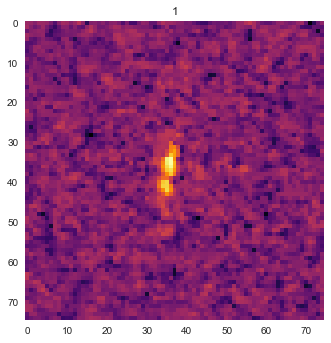

In [21]:
displayimage(gims,10)

In [17]:
import tensorflow as tf

In [42]:
def split_train_test(size, train_pc):
    ind = range(size)
    np.random.shuffle(ind)
    slice_split = int(train_pc*size)
    train_ind, test_ind = ind[:slice_split],ind[slice_split:]
    return train_ind, test_ind

In [43]:
train_ind, test_ind = split_train_test(len(label),train_pc=0.8)

In [51]:
Xtrain, Xval = gims[train_ind],gims[test_ind]
Ytrain, Yval = label[train_ind],label[test_ind]

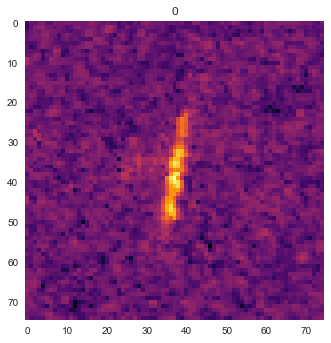

In [52]:
displayimage(Xtrain,3)

In [66]:
def generate_batch(Xdata, Ydata, batch_size):
    ind = range(len(Ydata))
    np.random.shuffle(ind)
    return Xdata[ind[:batch_size]], Ydata[ind[:batch_size]]

Creating the Tensorflow graph for the architecture

In [53]:
X = tf.placeholder(tf.float32,[None,75*75])
Y = tf.placeholder(tf.int32,[None,2])

In [56]:
W = tf.Variable(tf.truncated_normal(shape=[75*75,2],stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[2]))

In [57]:
y = tf.matmul(X,W) + b

In [58]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y))

In [59]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [69]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    